In [1]:
import torch
import numpy as np 
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Optimizer
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from useful_functions import *
from optimizer import *
from model import *
from MNIST_data_process import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from training import *
from mlxtend.data import mnist_data
from accuracy_compute import *
from data_preparation_easy import *
from data_preparation_hard import *
from network_func import *
from search_parameter import *
import optuna

In [4]:
import torch
torch.cuda.empty_cache()

In [2]:
import importlib

import data_preparation_hard
importlib.reload(data_preparation_hard)
from data_preparation_hard import *

import training
importlib.reload(training)
from training import *

import search_parameter
importlib.reload(search_parameter)
from search_parameter import *

import model
importlib.reload(model)
from model import *

In [2]:
# 一、 4层神经网络训练MNIST数据集：
# 【1】异质性观察
# 图1：pulldiag在di_ring(n=5)+三种不同异质性的表现(注：现在只弄了两种异质性，均匀分布和完全异质分布。能不能弄一个稍微混合一点的数据分布？比如在完全异质分布条件下，让1，2号节点数据混合一下。）
# 图2：pullsum在di_ring(n=5)+三种不同异质性的表现
# 图3：pulldiag和pullsum都在di_ring(n=5)或者di_ring(n=10)+强异质性下的对比表现

# 【2】拓扑影响
# 图1：在row_and_col_mat(n=10, p=0.5）+强异质性条件下比较pulldiag, pullsum, frsd, frozen 
# 图2：在row_and_col_mat(n=10, p=0.2）+强异质性条件下比较pulldiag, pullsum, frsd, frozen 
# 图3：只看pullsum, 在row_and_col_mat(n=10, p=0.5），row_and_col_mat(n=10, p=0.2），di_ring(n=10)，grid_10()上的表现。

In [21]:
# 【1】异质性观察
# 图1：pulldiag在di_ring(n=5)+三种不同异质性的表现(注：现在只弄了两种异质性，均匀分布和完全异质分布。能不能弄一个稍微混合一点的数据分布？比如在完全异质分布条件下，让1，2号节点数据混合一下。

<font color=blue>四层神经网络</font>

pulldiag在di_ring(n=5)+三种不同异质性的表现

均匀分布的数据：lr_opt = <font color=red>0.074</font>

极大异质性分布的数据: lr_opt = <font color=red>0.01313</font>
 
中等异质性分布的数据: lr_opt = <font color=red>0.04965</font>

A的第二大特征值: 0.7360318786212674
A的beta: 0.8102173609241421
A的spectral gap: 0.1897826390758579
A的kappa: 2.000000000000005
S_A是: 39.898193112709926 

1.8413e+00, 2.7000e+01


Training Progress: 100%|██████████| 1000/1000 [03:54<00:00,  4.26it/s, accuracy=98.0800000000%, epoch=1000, loss=0.1210031226]


A的第二大特征值: 0.7360318786212674
A的beta: 0.8102173609241421
A的spectral gap: 0.1897826390758579
A的kappa: 2.000000000000005
S_A是: 39.898193112709926 

1.8413e+00, 2.7000e+01


Training Progress: 100%|██████████| 1000/1000 [03:53<00:00,  4.28it/s, accuracy=89.2300000000%, epoch=1000, loss=0.2237082079]


A的第二大特征值: 0.7360318786212674
A的beta: 0.8102173609241421
A的spectral gap: 0.1897826390758579
A的kappa: 2.000000000000005
S_A是: 39.898193112709926 

1.8413e+00, 2.7000e+01


Training Progress: 100%|██████████| 1000/1000 [02:36<00:00,  6.40it/s, accuracy=94.2600000000%, epoch=1000, loss=0.1855913207]


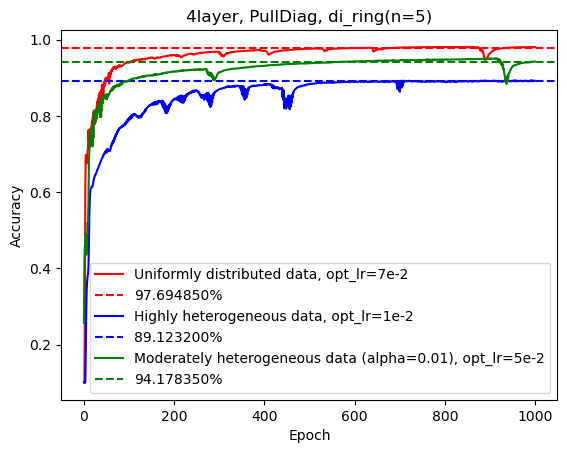

In [5]:
#均匀分布数据
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_5_hard_shuffled()

Diag_l0, Diag_a0 = train_PullDiag(
    n=n,
    A=A,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=1000,
    lr=0.074,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=False
)

#大异质性分布数据
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_5_hard()

Diag_l1, Diag_a1 = train_PullDiag(
    n=n,
    A=A,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=1000,
    lr=0.013,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=False
)

#混合分布数据 
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_5_hard_mix(alpha=0.01,seed=53)

Diag_l2, Diag_a2 = train_PullDiag(
    n=n,
    A=A,
    model_class=MNISTClassifier_2layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=1000,
    lr=0.04965,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=False
)

plt.plot(Diag_a0,color='r',label='Uniformly distributed data, opt_lr=7e-2')
number=np.mean(Diag_a0[800:])
plt.axhline(y=number, color='r', linestyle='--', label=f'{100*number:4f}%')
plt.plot(Diag_a1,color='b',label='Highly heterogeneous data, opt_lr=1e-2')
number=np.mean(Diag_a1[800:])
plt.axhline(y=number, color='b', linestyle='--', label=f'{100*number:4f}%')
plt.plot(Diag_a2,color='g',label='Moderately heterogeneous data (alpha=0.01), opt_lr=5e-2')
number=np.mean(Diag_a2[800:])
plt.axhline(y=number, color='g', linestyle='--', label=f'{100*number:4f}%')

plt.title("4layer, PullDiag, di_ring(n=5)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
import pandas as pd
df_U = pd.DataFrame({
    'Diag_l0': Diag_l0,
    'Diag_a0': Diag_a0
})
df_H = pd.DataFrame({
    'Diag_l1': Diag_l1,
    'Diag_a1': Diag_a1
})
df_M = pd.DataFrame({
    'Diag_l2': Diag_l2,
    'Diag_a2': Diag_a2
})
output_path_U = "/home/bluefog/GanLuo/PullSum_MNIST/code/神经网络实验/输出结果存放_画图使用/4layer_Diag_di_ring(n=5)的三种不同异质性表现/diag_U.csv"
output_path_H = "/home/bluefog/GanLuo/PullSum_MNIST/code/神经网络实验/输出结果存放_画图使用/4layer_Diag_di_ring(n=5)的三种不同异质性表现/diag_H.csv"
output_path_M = "/home/bluefog/GanLuo/PullSum_MNIST/code/神经网络实验/输出结果存放_画图使用/4layer_Diag_di_ring(n=5)的三种不同异质性表现/diag_M.csv"
df_U.to_csv(output_path_U, index=False)
df_H.to_csv(output_path_H, index=False)
df_M.to_csv(output_path_M, index=False)

In [ ]:
# 【1】异质性观察
# 图2：pullsum在di_ring(n=5)+三种不同异质性的表现

<font color=blue>四层神经网络</font>

pullsum在di_ring(n=5)+三种不同异质性的表现

均匀分布的数据：lr_opt = <font color=red>0.05592</font>

极大异质性分布的数据: lr_opt = <font color=red>0.00727</font>
 
中等异质性分布的数据: lr_opt = <font color=red>0.04486</font>

A的第二大特征值: 0.7360318786212674
A的beta: 0.8102173609241421
A的spectral gap: 0.1897826390758579
A的kappa: 2.000000000000005
S_A是: 39.898193112709926 

1.8413e+00, 2.7000e+01


Training Progress: 100%|██████████| 1000/1000 [03:55<00:00,  4.25it/s, accuracy=98.0500000000%, epoch=1000, loss=0.1238359898]


A的第二大特征值: 0.7360318786212674
A的beta: 0.8102173609241421
A的spectral gap: 0.1897826390758579
A的kappa: 2.000000000000005
S_A是: 39.898193112709926 

1.8413e+00, 2.7000e+01


Training Progress: 100%|██████████| 1000/1000 [02:36<00:00,  6.38it/s, accuracy=86.4900000000%, epoch=1000, loss=0.2702794254]


A的第二大特征值: 0.7360318786212674
A的beta: 0.8102173609241421
A的spectral gap: 0.1897826390758579
A的kappa: 2.000000000000005
S_A是: 39.898193112709926 

1.8413e+00, 2.7000e+01


Training Progress: 100%|██████████| 1000/1000 [02:39<00:00,  6.28it/s, accuracy=95.0000000000%, epoch=1000, loss=0.1615254916]


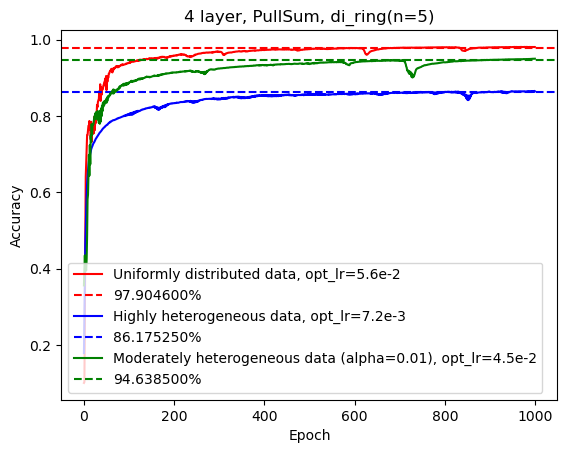

In [8]:
#均匀分布数据
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_5_hard_shuffled()

Sum_l0, Sum_a0 = train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=1000,
    lr=0.05593,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=False
)

#大异质性分布数据
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_5_hard()

Sum_l1, Sum_a1 = train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=MNISTClassifier_2layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=1000,
    lr=0.007272,#0.14534766737788476,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=False
)

#混合分布数据 
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_5_hard_mix(alpha=0.01,seed=53)

Sum_l2, Sum_a2 = train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=MNISTClassifier_2layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=1000,
    lr=0.04486,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=False
)

plt.plot(Sum_a0,color='r',label='Uniformly distributed data, opt_lr=5.6e-2')
number=np.mean(Sum_a0[800:])
plt.axhline(y=number, color='r', linestyle='--', label=f'{100*number:4f}%')
plt.plot(Sum_a1,color='b',label='Highly heterogeneous data, opt_lr=7.2e-3')
number=np.mean(Sum_a1[800:])
plt.axhline(y=number, color='b', linestyle='--', label=f'{100*number:4f}%')
plt.plot(Sum_a2,color='g',label='Moderately heterogeneous data (alpha=0.01), opt_lr=4.5e-2')
number=np.mean(Sum_a2[800:])
plt.axhline(y=number, color='g', linestyle='--', label=f'{100*number:4f}%')

plt.title("4 layer, PullSum, di_ring(n=5)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
import pandas as pd
df_U = pd.DataFrame({
    'Sum_l0': Sum_l0,
    'Sum_a0': Sum_a0
})
df_H = pd.DataFrame({
    'Sum_l1': Sum_l1,
    'Sum_a1': Sum_a1
})
df_M = pd.DataFrame({
    'Sum_l2': Sum_l2,
    'Sum_a2': Sum_a2
})
output_path_U = "/home/bluefog/GanLuo/PullSum_MNIST/code/神经网络实验/输出结果存放_画图使用/4layer_Sum_di_ring(n=5)的三种不同异质性表现/sum_U.csv"
output_path_H = "/home/bluefog/GanLuo/PullSum_MNIST/code/神经网络实验/输出结果存放_画图使用/4layer_Sum_di_ring(n=5)的三种不同异质性表现/sum_H.csv"
output_path_M = "/home/bluefog/GanLuo/PullSum_MNIST/code/神经网络实验/输出结果存放_画图使用/4layer_Sum_di_ring(n=5)的三种不同异质性表现/sum_M.csv"
df_U.to_csv(output_path_U, index=False)
df_H.to_csv(output_path_H, index=False)
df_M.to_csv(output_path_M, index=False)

In [14]:
# 一、 4层神经网络训练MNIST数据集：
# 【1】异质性观察
# 图3：pulldiag和pullsum都在di_ring(n=5)或者di_ring(n=10)+强异质性下的对比表现

<font color=blue>四层神经网络</font>

di_ring(n=5)

PullSum opt_lr = <font color=red>0.007272</font>

PullDiag opt_lr = <font color=red>0.013</font>

di_ring(n=10)

PullSum opt_lr = <font color=red>0.008147</font>

PullDiag opt_lr = <font color=red>0.001832</font>

A的第二大特征值: 0.7360318786212674
A的beta: 0.8102173609241421
A的spectral gap: 0.1897826390758579
A的kappa: 2.000000000000005
S_A是: 39.898193112709926 

1.8413e+00, 2.7000e+01


Training Progress: 100%|██████████| 1000/1000 [03:58<00:00,  4.19it/s, accuracy=86.0300000000%, epoch=1000, loss=0.5195783973]


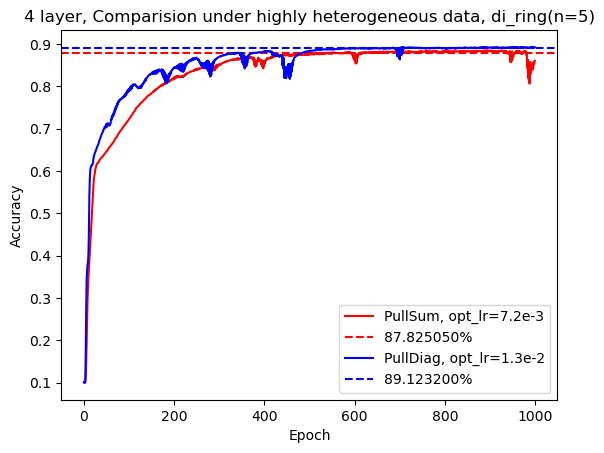

In [10]:
#大异质性分布数据
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_5_hard()

Diag_l1, Diag_a1 = train_PullDiag(
    n=n,
    A=A,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=1000,
    lr=0.013,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=False
)

Sum_l1, Sum_a1 = train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=1000,
    lr=0.007272,#0.14534766737788476,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=False
)

plt.plot(Sum_a1,color='r',label='PullSum, opt_lr=7.2e-3')
number=np.mean(Sum_a1[800:])
plt.axhline(y=number, color='r', linestyle='--', label=f'{100*number:4f}%')
plt.plot(Diag_a1,color='b',label='PullDiag, opt_lr=1.3e-2')
number=np.mean(Diag_a1[800:])
plt.axhline(y=number, color='b', linestyle='--', label=f'{100*number:4f}%')
plt.title("4 layer, Comparision under highly heterogeneous data, di_ring(n=5)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
import pandas as pd
df = pd.DataFrame({
    'Diag': Diag_a1,
    'Sum': Sum_a1
})
output_path = "/home/bluefog/GanLuo/PullSum_MNIST/code/神经网络实验/输出结果存放_画图使用/4layer_Sum_and_Diag_di_ring(n=5)强异质性对比/comparision.csv"
df.to_csv(output_path, index=False)

A的第二大特征值: 0.8814984307235881
A的beta: 0.9512126703474658
A的spectral gap: 0.048787329652534184
A的kappa: 2.000000000000005
S_A是: 219.49147627446277 

1.9567e+00, 6.1440e+02


Training Progress: 100%|██████████| 1000/1000 [10:01<00:00,  1.66it/s, accuracy=82.6100000000%, epoch=1000, loss=1.9927811146]


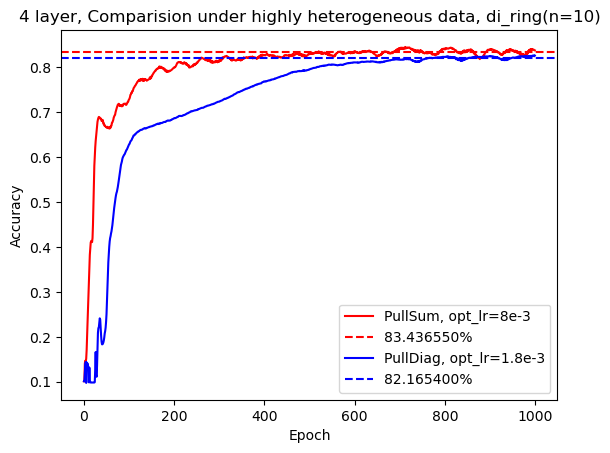

In [12]:
#大异质性分布数据
n=10
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_10_hard_linear_mix(p1=0.9,seed=49)#prepare_node_10_hard()#prepare_node_10_hard_mix(alpha=1e-2,seed=89)

Sum_ll, Sum_aa= train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=1000,
    lr=0.008147,#0.004734276782045016,#0.14534766737788476,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=False
)

Diag_ll, Diag_aa= train_PullDiag(
    n=n,
    A=A,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=1000,
    lr=0.00183,#0.004734276782045016,#0.14534766737788476,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=False
)

plt.plot(Sum_aa,color='r',label='PullSum, opt_lr=8e-3')
number=np.mean(Sum_aa[800:])
plt.axhline(y=number, color='r', linestyle='--', label=f'{100*number:4f}%')
plt.plot(Diag_aa,color='b',label='PullDiag, opt_lr=1.8e-3')
number=np.mean(Diag_aa[800:])
plt.axhline(y=number, color='b', linestyle='--', label=f'{100*number:4f}%')
plt.title("4 layer, Comparision under highly heterogeneous data, di_ring(n=10)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
import pandas as pd
df = pd.DataFrame({
    'Diag': Diag_aa,
    'Sum': Sum_aa
})
output_path = "/home/bluefog/GanLuo/PullSum_MNIST/code/神经网络实验/输出结果存放_画图使用/4layer_Sum_and_Diag_di_ring(n=10)强异质性对比/comparision.csv"
df.to_csv(output_path, index=False)

In [61]:
# 【2】拓扑影响
# 图1：在row_and_col_mat(n=10, p=0.5）+强异质性条件下比较pulldiag, pullsum, frsd, frozen 

<font color=blue>四层神经网络</font>

PullSum opt_lr = <font color=red>6e-3</font>(1e-2, 8e-3, 6e-3,都差不多, 但是更稳定)

PullDiag opt_lr = <font color=red>6e-3</font>

<font color=blue>四层神经网络，强异质性数据</font>

In [2]:
n=10
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=row_and_col_mat(n=10, p=0.5,seed=500)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A,epochs=1000)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_10_hard_linear_mix(p1=0.8,seed=49)

A的第二大特征值: 0.32539944913669683
A的beta: 0.5115868799970117
A的spectral gap: 0.4884131200029883
A的kappa: 4.610762702317021
S_A是: 32.74065042451158 

2.9511e+00, 2.9511e+01


Training Progress: 100%|██████████| 500/500 [03:49<00:00,  2.18it/s, accuracy=90.6800000000%, epoch=500, loss=1.7234230399]


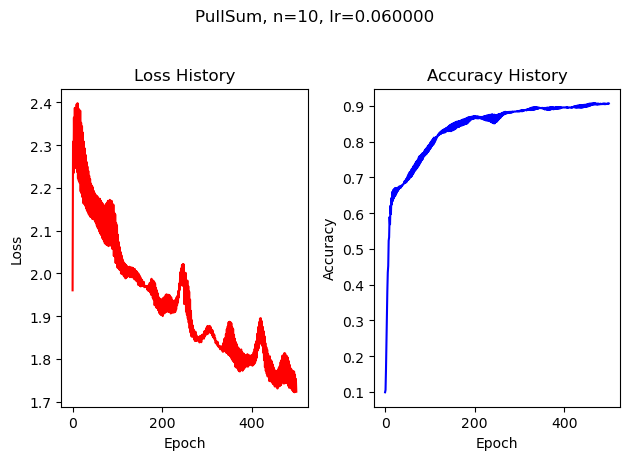

In [3]:
Sum_ll1, Sum_aa1= train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=500,
    lr=6e-3,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

Training Progress: 100%|██████████| 500/500 [03:44<00:00,  2.23it/s, accuracy=90.5300000000%, epoch=500, loss=1.7382048607]


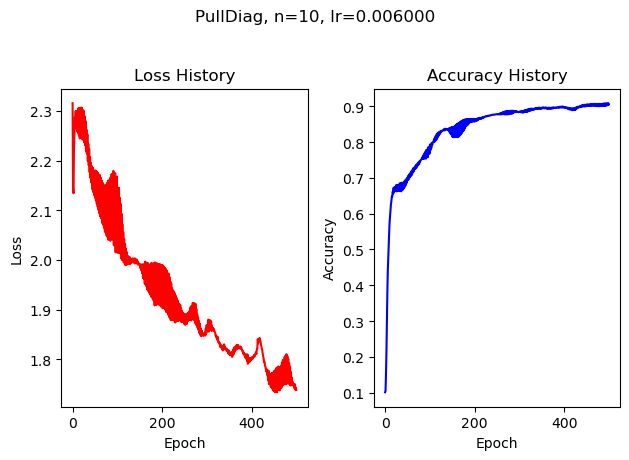

In [4]:
Diag_ll1, Diag_aa1= train_PullDiag(
    n=n,
    A=A,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=500,
    lr=6e-3,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

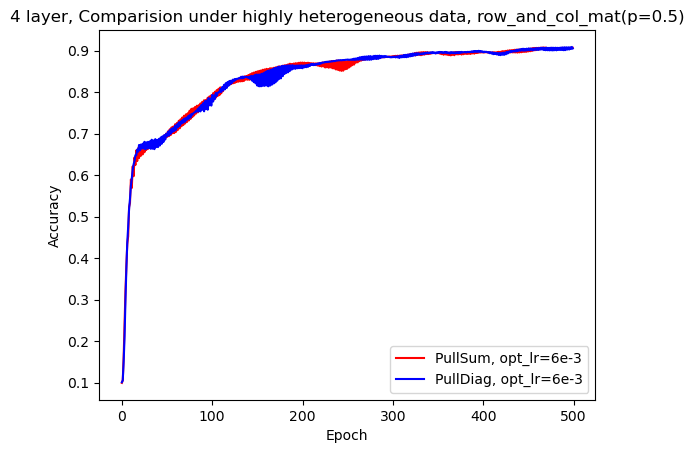

In [5]:
plt.plot(Sum_aa1,color='r',label='PullSum, opt_lr=6e-3')
plt.plot(Diag_aa1,color='b',label='PullDiag, opt_lr=6e-3')
plt.title("4 layer, Comparision under highly heterogeneous data, row_and_col_mat(p=0.5)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<font color=blue>个人觉得这个拓扑上的差别并不大</font>

<font color=blue>先看看在我之前跑通了的稀疏拓扑上的结果</font>

<font color=red>两层神经网络</font> 

<font color=blue>Pull Diag 最优参数：1e-3 </font>

<font color=blue>Pull Sum 最优参数：0.09 到 0.11 </font>

<font color=blue>FRSD 最优参数：pot_lr = 8e-4, opt_beta=1e-2(实际上, 1e-4到1e-1完全没有区别?) </font>

收敛速度上，Sum远远快于Diag

正确率上界上，Sum也更好

In [56]:
n=5
A = np.array([
    [2/3, 1/3, 1/3, 1/3, 1/3],
    [1/3, 1/3, 0, 0, 0],
    [0, 1/3, 1/3, 0, 0],
    [0, 0, 1/3, 1/3, 0],
    [0, 0, 0, 1/3, 2/3]
]).T
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}\n")
h_data,y_data,X_test,y_test=prepare_node_5_hard()

print(A,'\n')

print(A@np.ones(5))

A的第二大特征值: 1.0
A的beta: 0.7557727514481523
A的spectral gap: 0.24422724855184774
A的kappa: 8.000000000000002
S_A是: 56.388799044845726 

4.0500e+00, 4.0500e+01

[[0.66666667 0.33333333 0.         0.         0.        ]
 [0.33333333 0.33333333 0.33333333 0.         0.        ]
 [0.33333333 0.         0.33333333 0.33333333 0.        ]
 [0.33333333 0.         0.         0.33333333 0.33333333]
 [0.33333333 0.         0.         0.         0.66666667]] 

[1. 1. 1. 1. 1.]


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s, accuracy=12.3300000000%, epoch=2, loss=2.1421648264]

Training Progress: 100%|██████████| 1000/1000 [00:23<00:00, 41.87it/s, accuracy=83.6300000000%, epoch=1000, loss=0.4821823180]


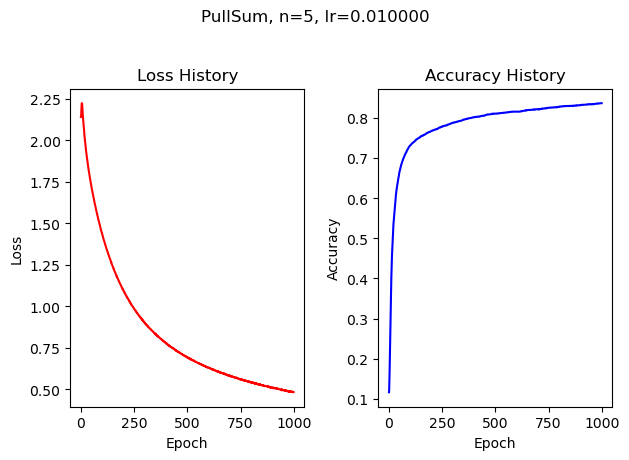

In [57]:
l1,a1=train_PullSum(n=n,A=A,B=B,model_class=MNISTClassifier_2layer_2_improve,seed_for_model=49,criterion_class=nn.CrossEntropyLoss,epochs=1000,lr=(1e-2/n),X_train_data=h_data,y_train_data=y_data,X_test_data=X_test,y_test_data=y_test,compute_accuracy=compute_accuracy_with_average_model,show_graph=True)

Training Progress: 100%|██████████| 1000/1000 [00:24<00:00, 41.19it/s, accuracy=85.6900000000%, epoch=1000, loss=0.2537414417]


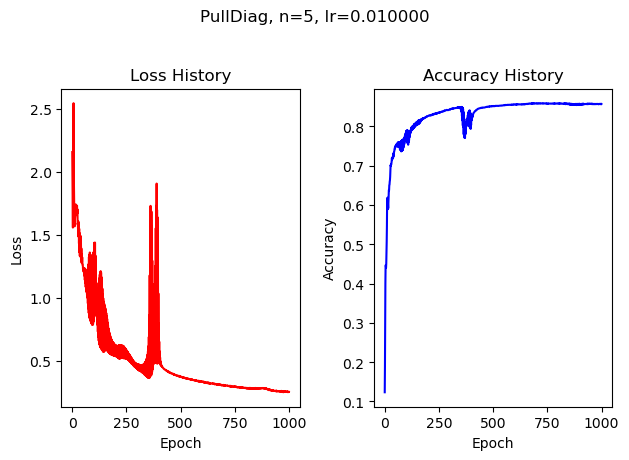

In [59]:
L1,A1=train_PullDiag(n=n,A=A,model_class=MNISTClassifier_2layer_2,seed_for_model=49,criterion_class=nn.CrossEntropyLoss,epochs=1000,lr=1e-2,X_train_data=h_data,y_train_data=y_data,X_test_data=X_test,y_test_data=y_test,compute_accuracy=compute_accuracy_with_average_model,show_graph=True)

In [2]:
n=5
a=0.996
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A=get_xinmeng_like_matrix(n,seed=85395).T
A=a*A+(1-a)*I
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}\n")
h_data,y_data,X_test,y_test=prepare_node_5_hard()

print(A)

A的第二大特征值: 0.5873611081378232
A的beta: 0.9192604747002416
A的spectral gap: 0.08073952529975836
A的kappa: 1.8348604358048821
S_A是: 89.00945641112506 

1.7882e+00, 5.7410e+05

[[0.03844671 0.96155329 0.         0.         0.        ]
 [0.08872106 0.27021236 0.64106658 0.         0.        ]
 [0.11110596 0.         0.30594487 0.58294917 0.        ]
 [0.48738936 0.         0.         0.01203197 0.50057867]
 [0.27402444 0.         0.         0.         0.72597556]]


In [16]:
L1,A1=train_PullDiag(n=n,A=A,model_class=MNISTClassifier_2layer_2,seed_for_model=49,criterion_class=nn.CrossEntropyLoss,epochs=1500,lr=(5e-3/n),X_train_data=h_data,y_train_data=y_data,X_test_data=X_test,y_test_data=y_test,compute_accuracy=compute_accuracy_with_average_model,show_graph=False)

l1,a1=train_PullSum(n=n,A=A,B=B,model_class=MNISTClassifier_2layer_2,seed_for_model=49,criterion_class=nn.CrossEntropyLoss,epochs=1500,lr=(0.1/n),X_train_data=h_data,y_train_data=y_data,X_test_data=X_test,y_test_data=y_test,compute_accuracy=compute_accuracy_with_average_model,show_graph=False)

Training Progress: 100%|██████████| 1500/1500 [02:38<00:00,  9.47it/s, accuracy=87.5400000000%, epoch=1500, loss=0.2007020488]


Training Progress: 100%|██████████| 1500/1500 [02:37<00:00,  9.54it/s, accuracy=67.5800000000%, epoch=1500, loss=1.2402481079]


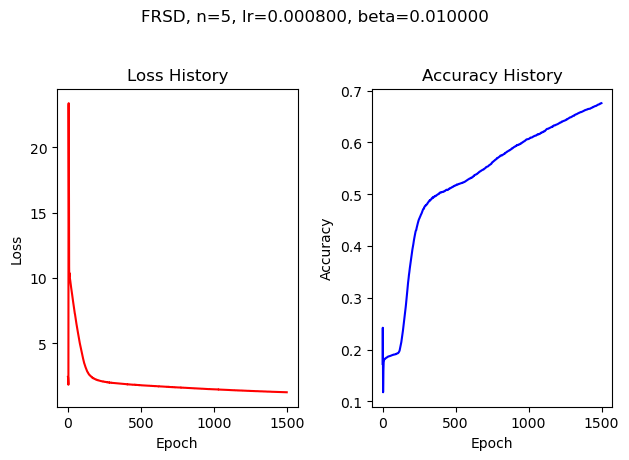

In [71]:
FRSDL2,FRDA2=train_FRSD(n=n,A=A,model_class=MNISTClassifier_2layer_2,seed_for_model=49,criterion_class=nn.CrossEntropyLoss,epochs=1500,lr=(8e-4),beta=1e-2,X_train_data=h_data,y_train_data=y_data,X_test_data=X_test,y_test_data=y_test,compute_accuracy=compute_accuracy_with_average_model,show_graph=True)

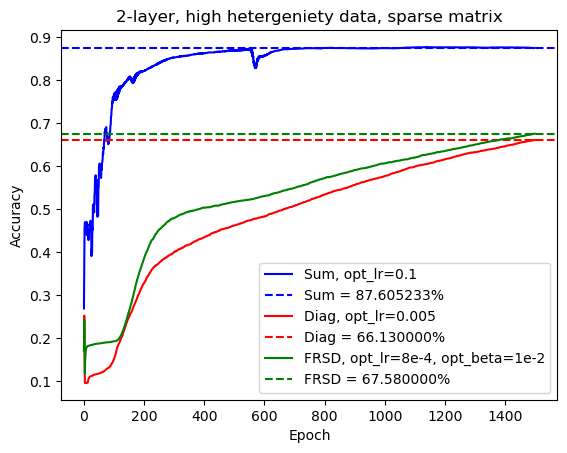

In [74]:
plt.plot(a1,color='b',label='Sum, opt_lr=0.1')
number=np.mean(a1[900:])
plt.axhline(y=number, color='b', linestyle='--', label=f'Sum = {100*number:4f}%')    
plt.plot(A1[:],color='r',label='Diag, opt_lr=0.005')
number=A1[1500-1]
plt.axhline(y=number, color='r', linestyle='--', label=f'Diag = {100*number:4f}%')
plt.plot(FRDA2[:],color='g',label='FRSD, opt_lr=8e-4, opt_beta=1e-2')
number=FRDA2[1500-1]
plt.axhline(y=number, color='g', linestyle='--', label=f'FRSD = {100*number:4f}%')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("2-layer, high hetergeniety data, sparse matrix")
plt.show()

In [ ]:
# 【2】拓扑影响
# 图1：在row_and_col_mat(n=10, p=0.5）+强异质性条件下比较pulldiag, pullsum, frsd, frozen 

两层神经网络

Diag opt_lr = 6e-3

Sum opt_lr = 4e-3 (5e-3 差不多)

FRSD opt_lr = 5e-3 (实际上 4e-3 到 8e-3 都差不多), opt_beta = 0.1 (似乎影响不大)

FROZEN opt_lr = 1e-3 (或许8e-4 更稳定), opt_lr = 1e-3(差不多)

In [30]:
n=10
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=row_and_col_mat(n=10, p=0.5,seed=49)#至少这个是可复现的——因为一次就找到了
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A,epochs=1000)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_10_hard_linear_mix(p1=0.9,seed=10)

A的第二大特征值: 0.307202151635153
A的beta: 0.5716937932186553
A的spectral gap: 0.4283062067813447
A的kappa: 4.569224215458886
S_A是: 37.2017184683376 

2.5679e+00, 2.5824e+01


Training Progress: 100%|██████████| 500/500 [01:03<00:00,  7.82it/s, accuracy=92.6100000000%, epoch=500, loss=1.8873741865]


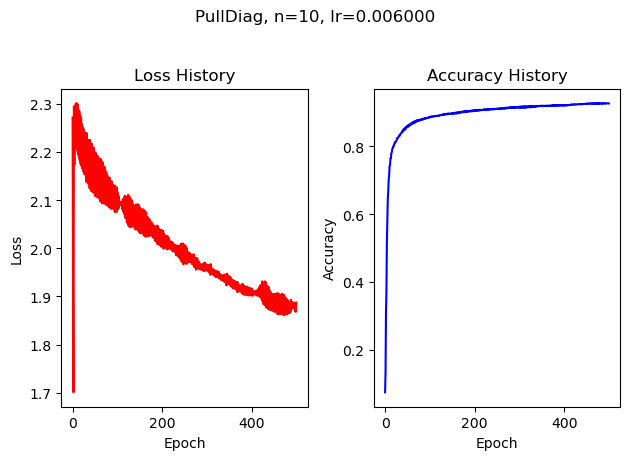

In [31]:
Diag_l, Diag_a= train_PullDiag(
    n=n,
    A=A,
    model_class=MNISTClassifier_2layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=500,
    lr=6e-3,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

Training Progress: 100%|██████████| 500/500 [01:02<00:00,  7.95it/s, accuracy=91.7700000000%, epoch=500, loss=1.8912809134]


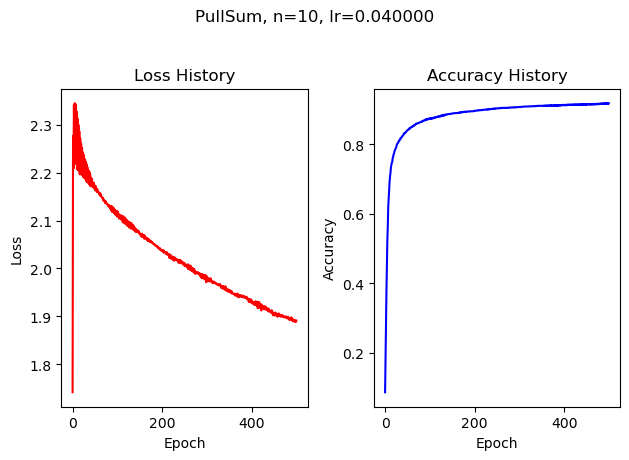

In [32]:
Sum_l, Sum_a= train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=MNISTClassifier_2layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=500,
    lr=4e-3,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

Training Progress: 100%|██████████| 500/500 [00:56<00:00,  8.83it/s, accuracy=92.4800000000%, epoch=500, loss=1.1886383653]


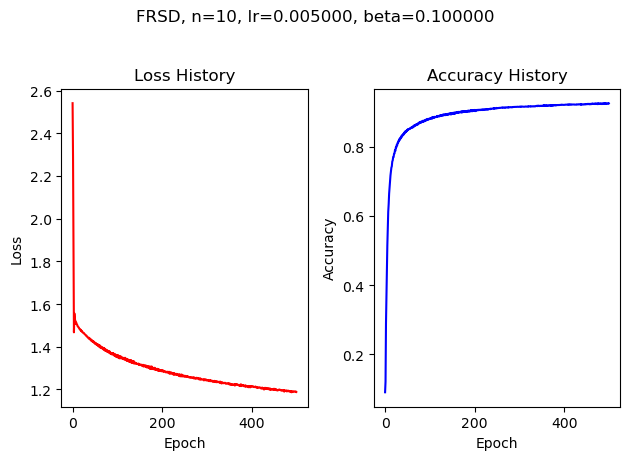

In [33]:
FRSD_l, FRSD_a= train_FRSD(
    n=n,
    A=A,
    model_class=MNISTClassifier_2layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=500,
    lr=5e-3,
    beta=0.1,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

Training Progress: 100%|██████████| 500/500 [00:58<00:00,  8.55it/s, accuracy=41.1200000000%, epoch=500, loss=2.2602535129]


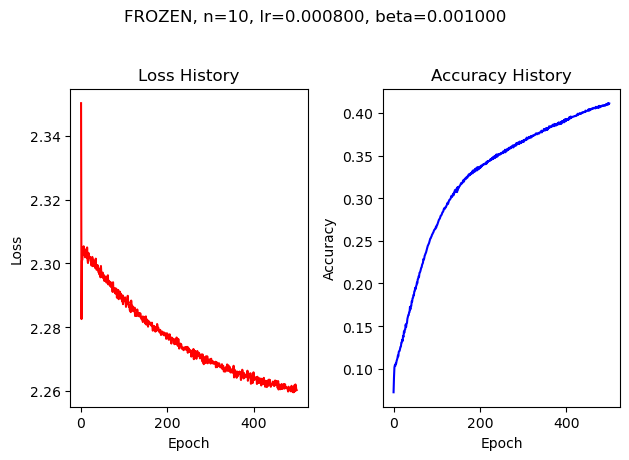

In [37]:
FROZEN_l2, FROZEN_a2= train_FROZEN(
    n=n,
    A=A,
    model_class=MNISTClassifier_2layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=500,
    lr=8e-4,
    beta=1e-3,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

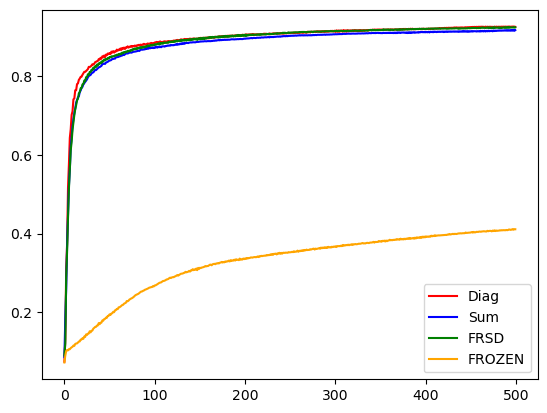

In [39]:
plt.plot(Diag_a,color='r',label="Diag")
plt.plot(Sum_a,color='b',label="Sum")
plt.plot(FRSD_a,color='g',label="FRSD")
plt.plot(FROZEN_a2,color='orange',label="FROZEN")
plt.legend()
plt.show()

In [38]:
import pandas as pd
df = pd.DataFrame({
    'Diag': Diag_a,
    'Sum': Sum_a,
    'FRSD': FRSD_a,
    'FROZEN': FROZEN_a2
})
output_path = "/home/ccy/luogan/远程仓库/code/神经网络实验/输出结果存放_画图使用/2layer_四个算法比较_row_mat(n=10,p=0.5)+强异质性条件/comparision.csv"
df.to_csv(output_path, index=False)

In [40]:
# 【2】拓扑影响
# 图2：在row_and_col_mat(n=10, p=0.2）+强异质性条件下比较pulldiag, pullsum, frsd, frozen 

四层神经网络

Diag opt_lr = 1e-3

Sum opt_lr = 1e-3

FRSD opt_lr = 2e-3, opt_beta = 0.1

FROZEN opt_lr = 1e-4 (烂完了)

In [28]:
n=10
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A = np.array([
    [0.2, 0.2, 0., 0., 0., 0.2, 0.2, 0., 0.2, 0.],
    [0., 0.2, 0., 0.2, 0., 0., 0., 0.2, 0.2, 0.2],
    [0.5, 0., 0.5, 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0.5, 0., 0., 0., 0.5, 0., 0.],
    [0., 0., 1/3, 1/3, 1/3, 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0.5, 0., 0., 0.5, 0.],
    [0., 0.2, 0., 0., 0., 0., 0.2, 0.2, 0.2, 0.2],
    [0., 0.5, 0., 0., 0., 0., 0., 0.5, 0., 0.],
    [0., 0., 0., 0., 1/3, 1/3, 0., 0., 1/3, 0.],
    [1/3, 1/3, 0., 0., 0., 0., 0., 0., 0., 1/3]
])#就是用p=0.2生成的，只不过没有可复现性，所以记录下来
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A,epochs=1000)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_10_hard_linear_mix(p1=0.9,seed=10)

A的第二大特征值: 0.7848631299562766
A的beta: 0.8896409449452245
A的spectral gap: 0.1103590550547755
A的kappa: 13.199999999999978
S_A是: 205.17826458661312 

7.2800e+00, 7.4374e+01


Training Progress: 100%|██████████| 500/500 [02:38<00:00,  3.15it/s, accuracy=72.7500000000%, epoch=500, loss=2.1943150520]


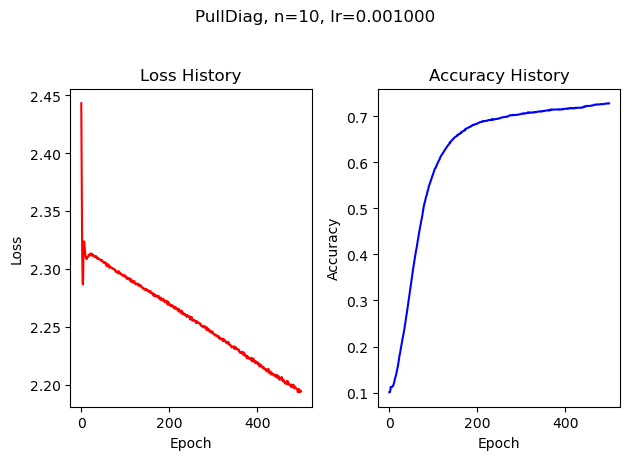

In [29]:
Diag_l, Diag_a= train_PullDiag(
    n=n,
    A=A,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=500,
    lr=1e-3,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

Training Progress: 100%|██████████| 500/500 [02:36<00:00,  3.20it/s, accuracy=72.7600000000%, epoch=500, loss=2.1940256357]


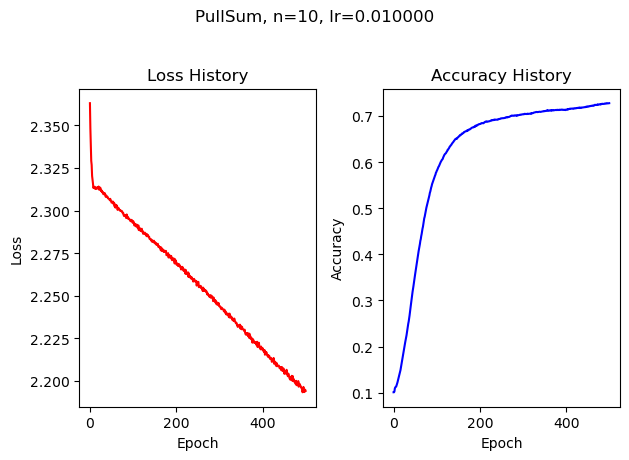

In [30]:
Sum_l, Sum_a= train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=500,
    lr=1e-3,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

Training Progress: 100%|██████████| 500/500 [02:22<00:00,  3.50it/s, accuracy=74.5500000000%, epoch=500, loss=1.8665661573]


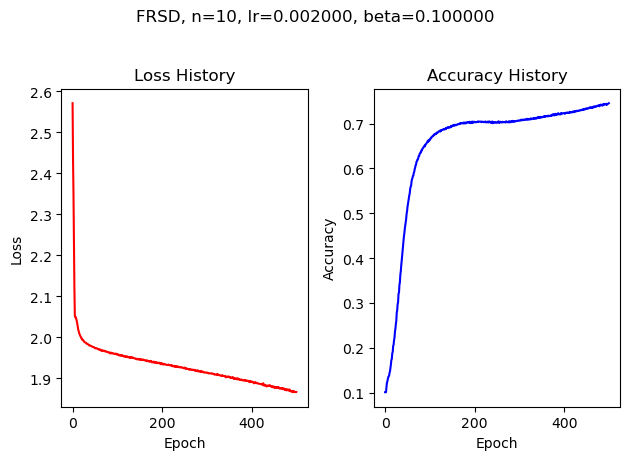

In [31]:
FRSD_l, FRSD_a= train_FRSD(
    n=n,
    A=A,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=500,
    lr=2e-3,
    beta=0.1,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

Training Progress: 100%|██████████| 500/500 [02:28<00:00,  3.37it/s, accuracy=14.4900000000%, epoch=500, loss=2.3131068468]


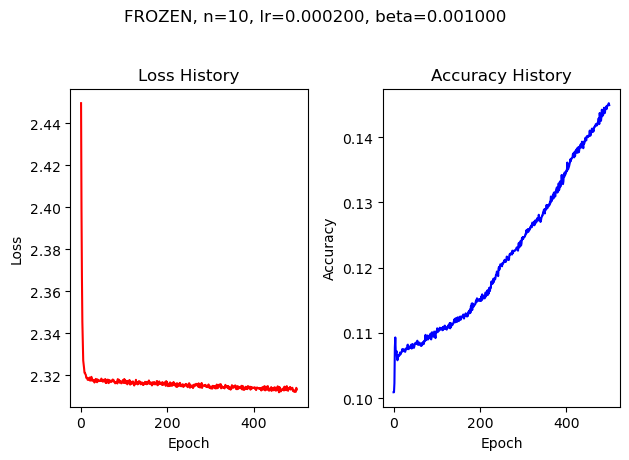

In [32]:
FROZEN_l, FROZEN_a= train_FROZEN(
    n=n,
    A=A,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=500,
    lr=2e-4,
    beta=1e-3,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

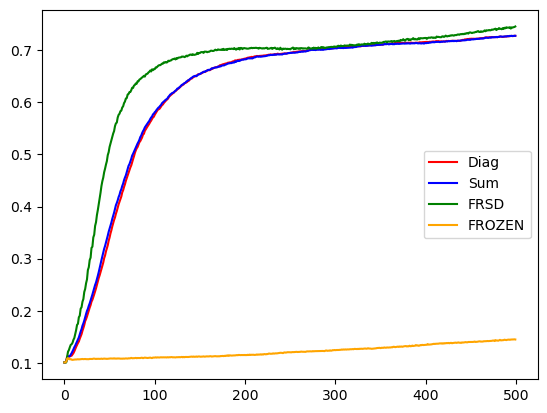

In [33]:
plt.plot(Diag_a,color='r',label="Diag")
plt.plot(Sum_a,color='b',label="Sum")
plt.plot(FRSD_a,color='g',label="FRSD")
plt.plot(FROZEN_a,color='orange',label="FROZEN")
plt.legend()
plt.show()

In [34]:
import pandas as pd
df = pd.DataFrame({
    'Diag': Diag_a,
    'Sum': Sum_a,
    'FRSD': FRSD_a,
    'FROZEN': FROZEN_a
})
output_path = "/home/ccy/luogan/远程仓库/code/神经网络实验/输出结果存放_画图使用/4layer_四个算法比较_row_mat(n=10,p=0.2)+强异质性条件/comparision.csv"
df.to_csv(output_path, index=False)

In [35]:
# 【2】拓扑影响
# 图3：只看pullsum, 在row_and_col_mat(n=10, p=0.5），row_and_col_mat(n=10, p=0.2），di_ring(n=10)，grid_10()上的表现。

四层神经网络



In [37]:
#大异质性分布数据
n=10
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_10_hard_linear_mix(p1=0.9,seed=10)

Sum_ll1, Sum_aa1= train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=500,
    lr=0.008147,#0.004734276782045016,#0.14534766737788476,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=False
)

A的第二大特征值: 0.8814984307235894
A的beta: 0.9512126703474658
A的spectral gap: 0.048787329652534184
A的kappa: 2.000000000000008
S_A是: 219.49147627446297 

1.9567e+00, 6.1440e+02


In [ ]:
n=10
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=row_and_col_mat(n=10, p=0.5,seed=49)#至少这个是可复现的——因为一次就找到了
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A,epochs=1000)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_10_hard_linear_mix(p1=0.9,seed=10)

Sum_ll2, Sum_aa2= train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=500,
    lr=3.5*1e-3,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

In [ ]:
n=10
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A = np.array([
    [0.2, 0.2, 0., 0., 0., 0.2, 0.2, 0., 0.2, 0.],
    [0., 0.2, 0., 0.2, 0., 0., 0., 0.2, 0.2, 0.2],
    [0.5, 0., 0.5, 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0.5, 0., 0., 0., 0.5, 0., 0.],
    [0., 0., 1/3, 1/3, 1/3, 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0.5, 0., 0., 0.5, 0.],
    [0., 0.2, 0., 0., 0., 0., 0.2, 0.2, 0.2, 0.2],
    [0., 0.5, 0., 0., 0., 0., 0., 0.5, 0., 0.],
    [0., 0., 0., 0., 1/3, 1/3, 0., 0., 1/3, 0.],
    [1/3, 1/3, 0., 0., 0., 0., 0., 0., 0., 1/3]
])#就是用p=0.2生成的，只不过没有可复现性，所以记录下来
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A,epochs=1000)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_10_hard_linear_mix(p1=0.9,seed=10)

Sum_l3, Sum_a3= train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=500,
    lr=1e-3,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

In [42]:
#大异质性分布数据
n=10
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=grid_10()
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_node_10_hard_linear_mix(p1=0.9,seed=10)

A的第二大特征值: 0.49652266833224246
A的beta: 0.9396926207859088
A的spectral gap: 0.06030737921409124
A的kappa: 2.000000000000003
S_A是: 177.5637268352975 

1.4497e+00, 2.4300e+02
